In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder

import xgboost

sns.set_theme(style="whitegrid")
sns.set_palette(palette="Paired")
SEED: int = 42

# Purpose of this notebook

Also try to use the coordinates as presented from the group 'Greyjoy'. 
But also add more information: The distance to the epicenter of the earthquake. 

In [61]:
train_data = pd.read_csv("../../data/raw/train_values.csv", index_col="building_id")
y_train = pd.read_csv("../../data/raw/train_labels.csv", index_col="building_id", usecols=["building_id", "damage_grade"])

In [3]:
encoder = LabelEncoder()
train_labels = encoder.fit_transform(y_train["damage_grade"].to_numpy())

In [21]:
geocoded_districts = pd.read_csv("../../data/processed/geocoded_districts_relative_number.csv")

In [22]:
geocoded_districts.head()

,dcode,district,loc,latitude,longitude,cases_absolute,cases_total,cases_relative
0,7,Dhankuta,POINT (830923.6221963036 2990403.9441179214),2.990404e+06,830923.622196,4491,996588,0.450638
1,9,Sankhuwasabha,POINT (823967.8875543519 3055813.003124751),3.055813e+06,823967.887554,4966,996588,0.498300
2,10,Bhojpur,POINT (804271.7821892153 3010893.8427118193),3.010894e+06,804271.782189,9242,996588,0.927364
3,11,Solukhumbhu,POINT (768535.2635735668 3068706.4528159057),3.068706e+06,768535.263574,17000,996588,1.705820
4,12,Okhaldhunga,POINT (739586.4122948735 3025872.434064191),3.025872e+06,739586.412295,36480,996588,3.660490


In [23]:
geocoded_districts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dcode           31 non-null     int64  
 1   district        31 non-null     object 
 2   loc             31 non-null     object 
 3   latitude        31 non-null     float64
 4   longitude       31 non-null     float64
 5   cases_absolute  31 non-null     int64  
 6   cases_total     31 non-null     int64  
 7   cases_relative  31 non-null     float64
dtypes: float64(3), int64(3), object(2)
memory usage: 2.1+ KB


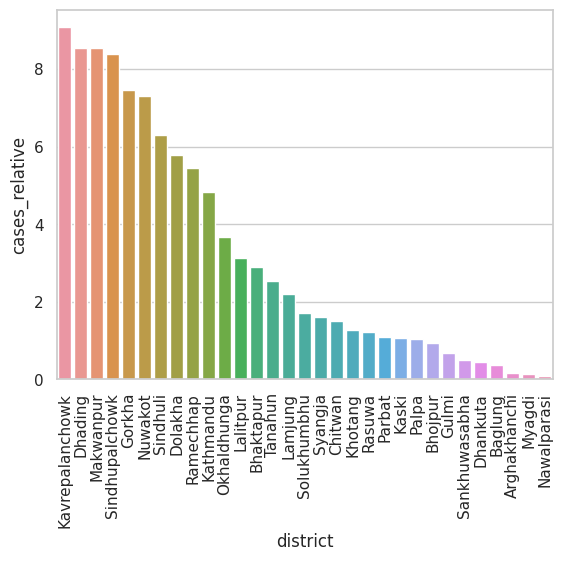

In [56]:
#plt.figure(figsize=(15,5))
g = sns.barplot(geocoded_districts.sort_values("cases_absolute", ascending=False),  
                x="district", 
                y="cases_relative",)

for item in g.get_xticklabels():
    item.set_rotation(90)
#g.set_xticklabels(rotation=90)

In [110]:
# Get distribution of our data set
result = pd.DataFrame(columns=["geo_level_1_id", "total"])

data = {
    "geo_level_1_id": train_data.reset_index()["geo_level_1_id"], 
    "total"         : [1] * train_data.shape[0]
}
result = pd.DataFrame(data=data)
result = result.groupby("geo_level_1_id").count()
result["ratio"] = 100 * result["total"] / train_data.shape[0]
result = result.reset_index().sort_values("total", ascending=False)

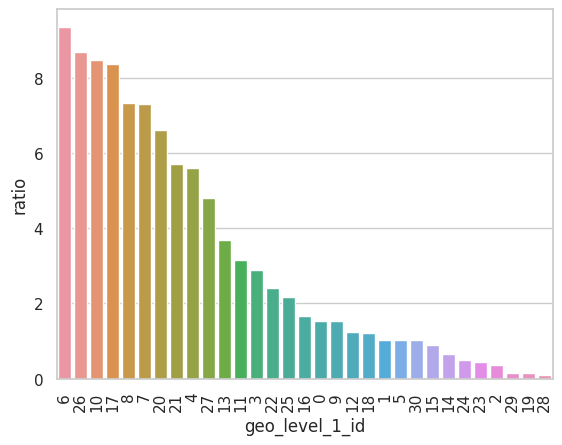

In [111]:
# Plot results
g = sns.barplot(result,  
                x="geo_level_1_id", 
                y="ratio",
                order=result.sort_values('ratio', ascending=False).geo_level_1_id)

for item in g.get_xticklabels():
    item.set_rotation(90)

The plots look pretty similar, also the values are similar.
(Also matches the information given in the presentation of the other group).

$\Rightarrow$ create a mapping between the geo_level_1_ids and the names and positions of the districts. 

In [118]:
sorted_geo_level_1_ids = list(result.sort_values('ratio', ascending=False).geo_level_1_id)

district_mapping = geocoded_districts.sort_values("cases_absolute", ascending=False)
district_mapping["geo_level_1_id"] = sorted_geo_level_1_ids
district_mapping.head()

,dcode,district,loc,latitude,longitude,cases_absolute,cases_total,cases_relative,geo_level_1_id
10,24,Kavrepalanchowk,POINT (660172.7511581221 3047402.9516771147),3.047403e+06,660172.751158,90497,996588,9.080683,6
16,30,Dhading,POINT (594662.4464236646 3093171.805756474),3.093172e+06,594662.446424,85255,996588,8.554689,26
17,31,Makwanpur,POINT (606893.011749543 3039579.495623507),3.039579e+06,606893.011750,85188,996588,8.547966,10
9,23,Sindhupalchowk,POINT (671458.8329532298 3089631.706769355),3.089632e+06,671458.832953,83589,996588,8.387518,17
19,36,Gorkha,POINT (577663.7704127206 3133385.98766555),3.133386e+06,577663.770413,74389,996588,7.464368,8


## Distance to epicenter

We can download the shapefile of Nepal along with its districts here: https://codefornepal.carto.com/tables/shape_files_of_districts_in_nepal/public

The information where the epicenter of the earthquake was can be found here: https://en.wikipedia.org/wiki/April_2015_Nepal_earthquake